# Evaluate embedding model

In [20]:
import os
import yaml
from collections import defaultdict
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [2]:
import torch
from torch_geometric.loader import DataLoader

In [3]:
from sphenix_fm.datasets.tpc_dataset import TPCDataset
from sphenix_fm.utils import Checkpointer

In [4]:
from processor import Processor
from models import HingeLoss

In [5]:
from sphenix_benchmark.metrics import compute_roc, compute_pr
from sphenix_benchmark.plots.plots import plot_distribution, plot_roc_curve, plot_pr_curve

In [6]:
! nvidia-smi

Mon Jun  9 15:04:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               Off |   00000000:01:00.0 Off |                  Off |
| 58%   81C    P0            232W /  300W |   31572MiB /  49140MiB |     35%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Load data and model

In [7]:
# set up device
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
gpu_id = 0
torch.cuda.set_device(gpu_id)
device = 'cuda'

# load configuration
config_fname = 'config.yaml'
with open(config_fname, 'r', encoding='UTF-8') as handle:
    config = yaml.safe_load(handle)

# load data
valid_ds  = TPCDataset(split='test', **config['data'])
valid_ldr = DataLoader(valid_ds,
                       batch_size = 1,
                       shuffle    = True)

# data processor
data_processor = Processor(**config['data_processor'])

# construct and load model
epoch = 'last'
model = torch.jit.load(f'checkpoints/ckpt_{epoch}.script')
model.to(device)

loss_fn = HingeLoss()


Loaded 13193 events from /home/sphenix_fm/data/pp_100k_mmap-with_charge!



## Evaluate one event

number of queries = 106610
same-track queries = 56375
diff-track queries = 50235


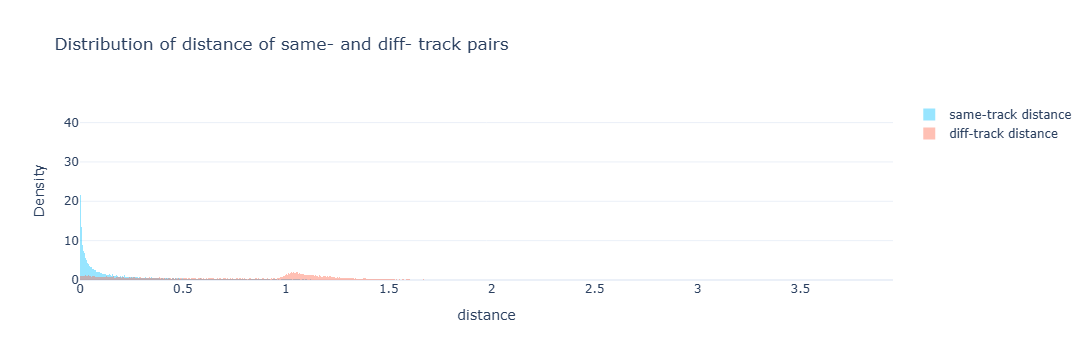

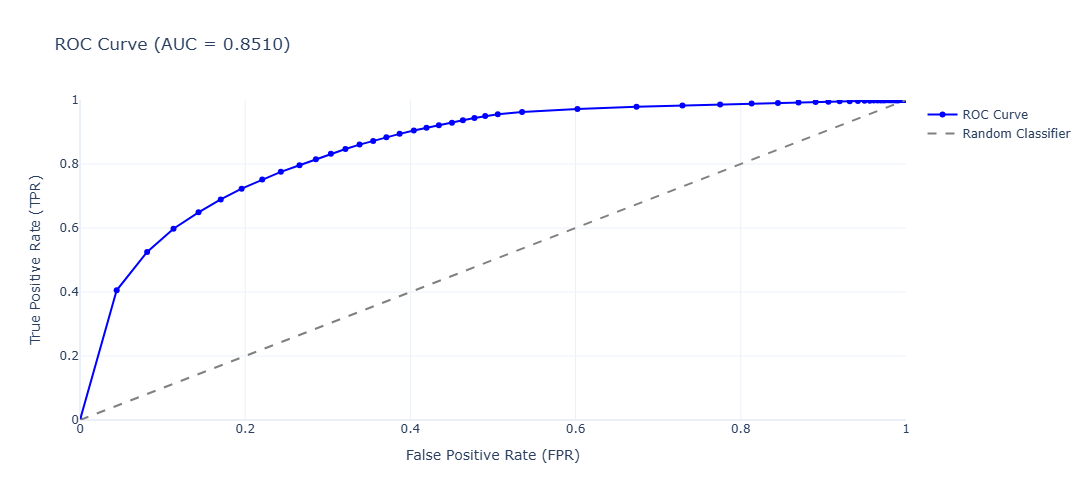

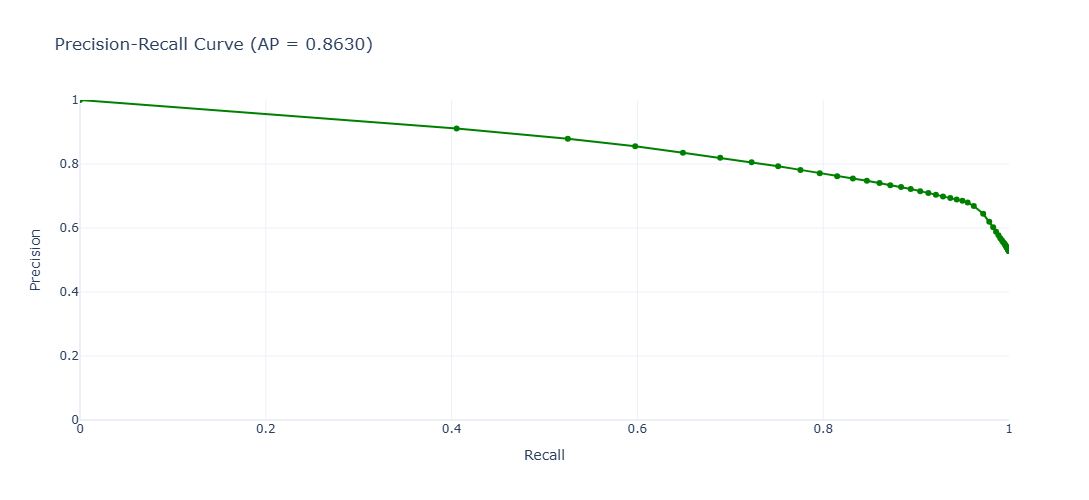

In [23]:
data = next(iter(valid_ldr))
points    = data['features'].x.to(device)
track_ids = data['seg_target'].x.to(device)
batch     = data['features'].batch.to(device)

# processing input
head, tail, labels, stats = data_processor(
    points      = points,
    track_ids   = track_ids,
    batch       = batch,
    projection  = model,
    return_stat = True
)

# calculate embeddings
with torch.no_grad():
    emb_head = model(head)
    emb_tail = model(tail)
    _, dist = loss_fn(emb_head, emb_tail, labels, return_dist=True)

print(f'number of queries = {len(head)}')
print(f'same-track queries = {len(dist[labels])}')
print(f'diff-track queries = {len(dist[~labels])}')

# Calculate and evaluate performance 
plot_distribution(dist, labels, data_type='distance', log_y=False, vmax=dist.max().item())
# ROC curve
fpr, tpr, auc = compute_roc(dist, labels, num_thresholds=100, reverse=True)
plot_roc_curve(fpr, tpr, auc)
# PR curve
recall, precision, average_precision = compute_pr(dist, labels, num_thresholds=100, reverse=True)
plot_pr_curve(recall, precision, average_precision)

## per event adjacency and distance matrix

In [9]:
valid_ldr = DataLoader(valid_ds, batch_size=1, shuffle=True)
data = next(iter(valid_ldr))
points    = data['features'].x.to(device)
track_ids = data['seg_target'].x.to(device)

adj_matrix = track_ids.unsqueeze(0) == track_ids.unsqueeze(1)

with torch.no_grad():
    inputs = data_processor.get_inputs(points)
    emb = model(inputs)
    distance = torch.pow(emb.unsqueeze(1) - emb.unsqueeze(0), 2).sum(-1)

threshold = 2
recall = ((distance < threshold) & adj_matrix).sum() / adj_matrix.sum()
precision = ((distance < threshold) & adj_matrix).sum() / (distance < threshold).sum()
print(recall, precision)
true_neg_rate = ((distance > threshold) * (~adj_matrix)).sum() / (~adj_matrix).sum()
print(true_neg_rate)

torch.where(distance < threshold)

tensor(0.6665, device='cuda:0') tensor(0.3283, device='cuda:0')
tensor(0.5209, device='cuda:0')


(tensor([  0,   0,   0,  ..., 667, 667, 667], device='cuda:0'),
 tensor([  0,   1,   2,  ..., 665, 666, 667], device='cuda:0'))

In [10]:
valid_ldr = DataLoader(valid_ds, batch_size=1, shuffle=True)

pbar = tqdm(valid_ldr, total=len(valid_ldr))

thresholds = np.linspace(1, 2.5, 16)
dfs = []
for data in pbar:
    points    = data['features'].x.to(device)
    track_ids = data['seg_target'].x.to(device)

    adj_matrix = track_ids.unsqueeze(0) == track_ids.unsqueeze(1)

    with torch.no_grad():
        inputs = data_processor.get_inputs(points)
        emb = model(inputs)
        distance = torch.pow(emb.unsqueeze(1) - emb.unsqueeze(0), 2).sum(-1)

    stats = defaultdict(list)
    for threshold in thresholds:
        stats['tp'].append(((distance < threshold) & adj_matrix).sum().item())
        stats['tn'].append(((distance > threshold) & (~adj_matrix)).sum().item())
        stats['fp'].append(((distance < threshold) & (~adj_matrix)).sum().item())
        stats['fn'].append(((distance > threshold) & (adj_matrix)).sum().item())
        stats['threshold'].append(threshold)
    
    df = pd.DataFrame(data=stats)
    df['num_nodes'] = len(points)
    
    dfs.append(df)

  0%|          | 0/13193 [00:00<?, ?it/s]

## Evaluation all test events and find a threshold

In [11]:
df_combined = pd.concat(dfs, axis=0)
df_combined.to_csv('results/threshold_per_event.csv')

In [14]:
df_combined

tp      tn      fp     fn  threshold  num_nodes
0   36260  246462   14650  84552        1.0        618
1   39842  237002   24110  80970        1.1        618
2   43504  224172   36940  77308        1.2        618
3   46958  215034   46078  73854        1.3        618
4   50870  206028   55084  69942        1.4        618
..    ...     ...     ...    ...        ...        ...
11  88567  181800  247518  13556        2.1        729
12  91521  159590  269728  10602        2.2        729
13  94433  141822  287496   7690        2.3        729
14  96497  127322  301996   5626        2.4        729
15  98181  112620  316698   3942        2.5        729

[211088 rows x 6 columns]

In [17]:
data = {'tp': [], 'fn': [], 'fp': [], 'tn': []}
for threshold in thresholds:
    df_sel = df_combined[ df_combined.threshold == threshold ]
    total = (df_sel.tp + df_sel.tn + df_sel.fp + df_sel.fn).sum()
    for key in ['tp', 'fn', 'fp', 'tn']:
        data[key].append(df_sel[key].sum() / total)

data['threshold'] = thresholds
df_thr = pd.DataFrame(data=data)

df_thr['recall'] = df_thr.tp / (df_thr.tp + df_thr.fn)
df_thr['precision'] = df_thr.tp / (df_thr.tp + df_thr.fp)
df_thr['fpr'] = df_thr.fp / (df_thr.tn + df_thr.fp)
df_thr.to_csv(f'results/threshold.csv', index=False)
df_thr

tp        fn        fp        tn  threshold    recall  precision  \
0   0.055663  0.065833  0.043381  0.835123        1.0  0.458145   0.562003   
1   0.062135  0.059361  0.073347  0.805157        1.1  0.511417   0.458621   
2   0.066714  0.054782  0.107834  0.770670        1.2  0.549104   0.382210   
3   0.070705  0.050791  0.142627  0.735877        1.3  0.581955   0.331433   
4   0.074492  0.047005  0.179127  0.699377        1.4  0.613119   0.293714   
5   0.078235  0.043261  0.218430  0.660074        1.5  0.643931   0.263715   
6   0.082028  0.039468  0.260767  0.617737        1.6  0.675151   0.239292   
7   0.085876  0.035620  0.305793  0.572711        1.7  0.706821   0.219257   
8   0.089826  0.031670  0.352593  0.525911        1.8  0.739329   0.203033   
9   0.093818  0.027678  0.400517  0.477987        1.9  0.772191   0.189787   
10  0.097792  0.023704  0.448887  0.429617        2.0  0.804902   0.178884   
11  0.101695  0.019801  0.497105  0.381399        2.1  0.837021   0.169831   
12  0.105469  0.016027  0.544657  0.333847        2.2  0.868090   0.162229   
13  0.109038  0.012458  0.590926  0.287578        2.3  0.897463   0.155777   
14  0.112336  0.009160  0.635374  0.243130        2.4  0.924608   0.150240   
15  0.115172  0.006324  0.677096  0.201408        2.5  0.947947   0.145370   

         fpr  
0   0.049380  
1   0.083491  
2   0.122747  
3   0.162352  
4   0.203901  
5   0.248639  
6   0.296831  
7   0.348083  
8   0.401356  
9   0.455908  
10  0.510967  
11  0.565854  
12  0.619983  
13  0.672651  
14  0.723245  
15  0.770737

In [18]:
valid_ds  = TPCDataset(split='test', **config['data'])
valid_ldr = DataLoader(valid_ds, batch_size=64, shuffle=True)
pbar = tqdm(valid_ldr)

dfs = []
for data in pbar:
    points    = data['features'].x.to(device)
    track_ids = data['seg_target'].x.to(device)
    batch     = data['features'].batch.to(device)
    
    head, tail, labels, stat = data_processor(
        points      = points,
        track_ids   = track_ids,
        batch       = batch,
        # projection  = model,
        projection  = None,
        return_stat =True
    )
    print(stat)
    break


Loaded 13193 events from /home/sphenix_fm/data/pp_100k_mmap-with_charge!



  0%|          | 0/207 [00:00<?, ?it/s]

{'knn_pos_ratio': 0.15699924528598785, 'num_knn_queries': 119370, 'random_pos_ratio': 0.13080894947052002, 'num_random_queries': 1162}


To-Do: calculate classification metric separately on KNN and randome pairs. 